In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import numpy as np
from kernels import HMC_vanilla

%matplotlib inline

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS

# Notebook with simple experiments

## Task 1

### Receiving of the true $\theta$ and generating of a dataset

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

z_dim = 2 # Latent space dimensionality
data_dim = 10 # Data dimensionality
N = 10000 # Dataset size
N_val = 1000 # Validation Dataset

sigma_0 = 1. # True std

In [3]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
std_normal_pyro = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
true_theta = std_normal.sample((z_dim, data_dim)) * sigma_0
print('True decoder matrix')
print(true_theta)
print('-' * 100)

data_probs = torch.sigmoid(std_normal.sample((N, z_dim)) @ true_theta)
data = torch.distributions.Bernoulli(probs=data_probs).sample()

data_probs_val = torch.sigmoid(std_normal.sample((N_val, z_dim)) @ true_theta)
data_val = torch.distributions.Bernoulli(probs=data_probs_val).sample()

print('Generated data example:')
print(data[:10])

True decoder matrix
tensor([[ 1.4355,  0.3056,  0.8280,  0.6888,  1.1489, -1.3866,  2.0173,  0.4863,
         -1.1018, -0.3557],
        [-0.5600,  2.2589,  0.2156, -1.5480, -0.1137, -0.9660,  0.7995,  0.9915,
          1.1478,  3.1978]], device='cuda:0')
----------------------------------------------------------------------------------------------------
Generated data example:
tensor([[1., 0., 1., 1., 1., 0., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 1., 0., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1., 1., 0.],
        [0., 0., 1., 1., 0., 1., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0., 0., 0., 1., 1., 0.]], device='cuda:0')


## Task 2

### Sample z with target $p(z|x)$, using NUTS

#### 1) Bernoulli likelihood from torch

In [4]:
n_warmup = 20000
n_samples = 1000

data_ind = 0  #  index of datapoint we conditioned on

In [5]:
def potential_fn(z):
    z = z['points']
    probs = torch.sigmoid(z @ true_theta)
    return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(data[data_ind][None]).sum(1) + std_normal_pyro.log_prob(z).sum(1))

In [6]:
init_samples = std_normal_pyro.sample((1, z_dim))
init_params = {'points': init_samples}

nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel,
            initial_params=init_params,
            num_samples=n_samples,
            warmup_steps=n_warmup)

mcmc.run()
z = mcmc.get_samples()['points'].squeeze()

Sample: 100%|██████████| 21000/21000 [01:55, 182.28it/s, step size=9.07e-01, acc. prob=0.904]


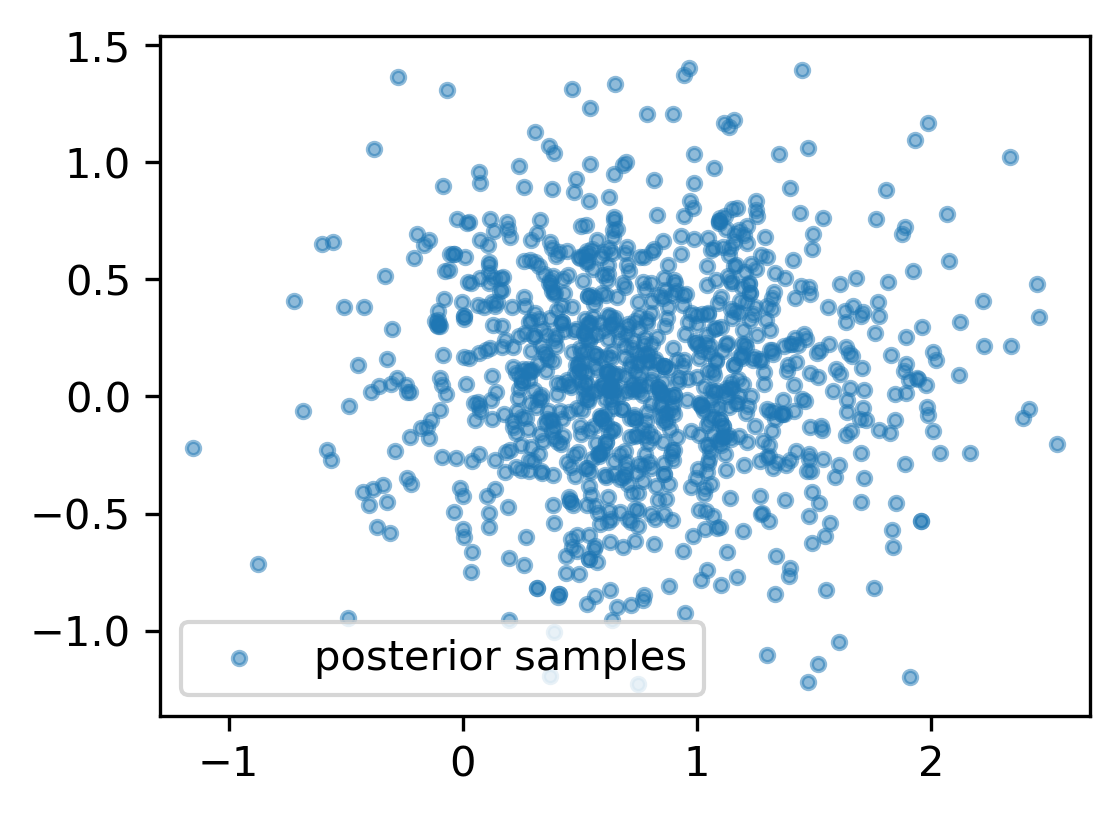

In [7]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.5)
plt.legend()
plt.axis('equal');

### Sample z with target $p(z|x)$, using our HMC

In [8]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict({})

args.device = device

args.N = 5

args.alpha = 0.5
args.use_partialref = False

args.gamma = 0.1
args.use_barker = True

In [9]:
class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x):
        probs = torch.sigmoid(z @ true_theta)
        return torch.distributions.Bernoulli(probs=probs).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1)
target = Target()

In [10]:
transitions = HMC_vanilla(args)
z = std_normal.sample((1, z_dim))
momentum = std_normal.sample(z.shape)

print('Warm up')
for i in tqdm(range(n_warmup)):
    z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=data[data_ind][None])
    
print('Sampling')
samples = []
for i in tqdm(range(n_samples)):
    z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=data[data_ind][None])
    samples.append(z.cpu().detach().numpy())

  0%|          | 15/20000 [00:00<02:14, 148.43it/s]

Warm up


  2%|▏         | 16/1000 [00:00<00:06, 157.66it/s]

Sampling


100%|██████████| 1000/1000 [00:06<00:00, 151.80it/s]


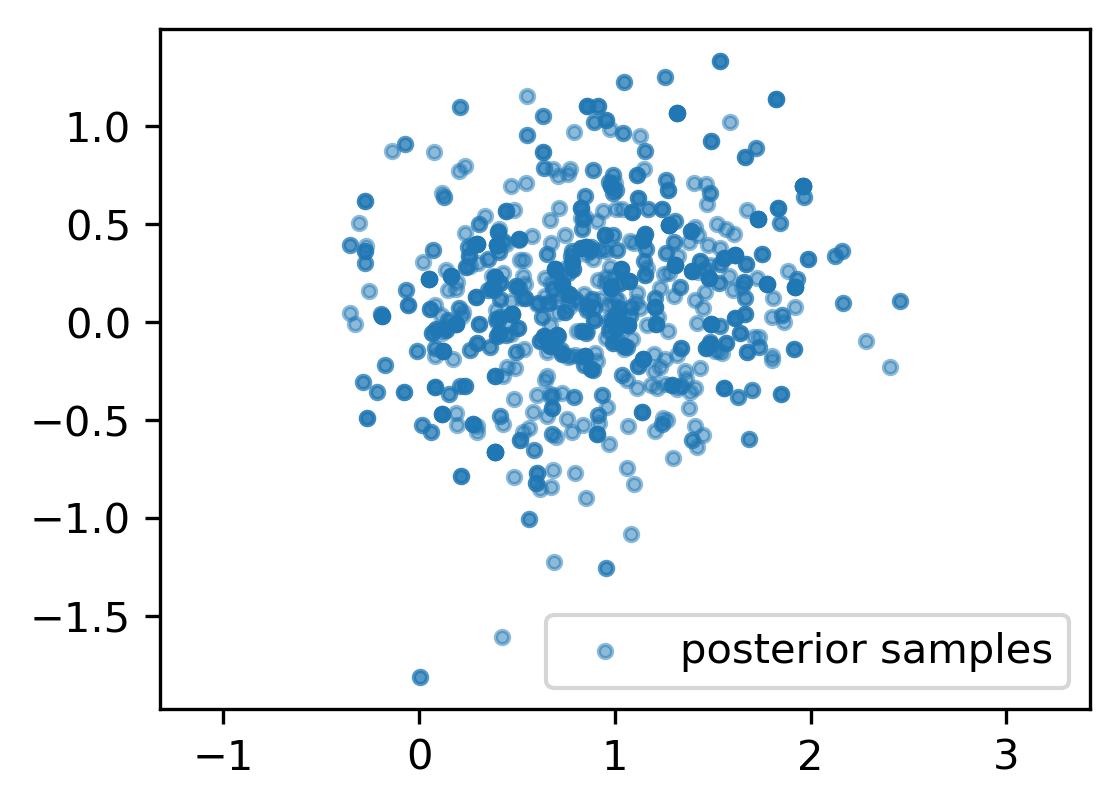

In [11]:
samples = np.array(samples).squeeze()

plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(samples[:, 0], samples[:, 1], label='posterior samples', s=10, alpha=0.5)
plt.legend()
plt.axis('equal');

## Task 3

#### Fisher's identity, NUTS

In [12]:
class Decoder(nn.Module):
    def __init__(self, data_dim, z_dim):
        super(Decoder, self).__init__()
        self.W = nn.Linear(in_features=z_dim, out_features=data_dim, bias=False)
    def forward(self, z):
        return self.W(z)

In [13]:
# num_epoches = 10
# batch_size = 1
# n_samples = 10
# n_warmup = 50

# print_info_ = 1

In [14]:
# dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [15]:
# dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)
# optimizer = torch.optim.Adam(params=dec.parameters(), lr=3e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')

In [16]:
# def potential_fn(z):
#     z = z['points']
#     probs = torch.sigmoid(z @ current_matrix)
#     return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(batch_train).sum(1) + std_normal_pyro.log_prob(z).sum(1))

In [17]:
# for ep in tqdm(range(num_epoches)): # cycle over epoches
#     plt.close()
#     j = 0
#     obj_sum = 0
#     for b_num, batch_train in enumerate(dataloader): # cycle over batches
        
#         init_samples = std_normal.sample((batch_train.shape[0], z_dim))
#         init_params = {'points': init_samples}
        
#         current_matrix = dec.W.weight.detach().T
        
#         nuts_kernel = NUTS(potential_fn=potential_fn)
#         mcmc = MCMC(nuts_kernel,
#                     initial_params=init_params,
#                     num_samples=n_samples,
#                     warmup_steps=n_warmup,
#                    disable_progbar=True)
#         mcmc.run()
#         z = mcmc.get_samples()['points'][-n_samples:]
        
# #         pdb.set_trace()
        
#         probs = torch.sigmoid(dec(z))
#         obj = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean(0).sum(1).mean()

#         (-obj).backward()
#         optimizer.step()
#         optimizer.zero_grad()
        
#         j += 1
#         obj_sum += obj.cpu().detach().numpy()
# #     scheduler.step(obj)
#     obj_sum /= j
#     if ep % print_info_ == 0:
#         print('obj mean over epoch:', obj_sum.cpu().detach().item())
#         print('obj:', obj.cpu().detach().item())

In [18]:
# print('true_theta', true_theta)
# print('-' * 100)
# print(dec.W.weight.detach().T)

#### Fisher's identity, our HMC

In [19]:
num_epoches = 500
batch_size = 200

print_info_ = 50

args.K = 5
args.N = 2

In [20]:
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [21]:
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(params=dec.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')

transitions = HMC_vanilla(args)

In [22]:
class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x):
        probs = torch.sigmoid(dec(z))
        return torch.distributions.Bernoulli(probs=probs).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1)
target = Target()

In [23]:
for ep in tqdm(range(num_epoches)): # cycle over epoches
    j = 0
    obj_sum = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        
        momentum = std_normal.sample((batch_train.shape[0], z_dim))
        z = std_normal.sample((batch_train.shape[0], z_dim))
        for p in dec.parameters():
            p.requires_grad_(False)

        for _ in range(args.K):
            z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=batch_train)
            
        for p in dec.parameters():
            p.requires_grad_(True)
        
        
        probs = torch.sigmoid(dec(z))
        obj = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean()

        (-obj).backward()
        optimizer.step()
        optimizer.zero_grad()
        
        j += 1
        obj_sum += obj.cpu().detach().numpy()
#     scheduler.step(obj)
    obj_sum /= j
    if ep % print_info_ == 0:
        print('obj mean over epoch:', obj_sum)
        print('obj:', obj.cpu().detach().item())

  0%|          | 1/500 [00:01<09:01,  1.09s/it]

obj mean over epoch: -0.7275189995765686
obj: -0.7201770544052124


 10%|█         | 51/500 [00:55<08:08,  1.09s/it]

obj mean over epoch: -0.6935044240951538
obj: -0.6924172639846802


 20%|██        | 101/500 [01:49<07:12,  1.09s/it]

obj mean over epoch: -0.6931404280662536
obj: -0.6933335065841675


 30%|███       | 151/500 [02:43<06:17,  1.08s/it]

obj mean over epoch: -0.6931681084632874
obj: -0.6933349967002869


 40%|████      | 201/500 [03:38<05:24,  1.09s/it]

obj mean over epoch: -0.6931814730167389
obj: -0.692981481552124


 50%|█████     | 251/500 [04:32<04:27,  1.08s/it]

obj mean over epoch: -0.693145762681961
obj: -0.6931185126304626


 60%|██████    | 301/500 [05:26<03:37,  1.09s/it]

obj mean over epoch: -0.6931619656085968
obj: -0.6930907368659973


 70%|███████   | 351/500 [06:21<02:43,  1.09s/it]

obj mean over epoch: -0.69313472032547
obj: -0.6930304169654846


 80%|████████  | 401/500 [07:16<01:48,  1.10s/it]

obj mean over epoch: -0.6931559455394745
obj: -0.6933451294898987


 90%|█████████ | 451/500 [08:10<00:53,  1.09s/it]

obj mean over epoch: -0.6931673049926758
obj: -0.6931715607643127


100%|██████████| 500/500 [09:04<00:00,  1.09s/it]


In [24]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)

true_theta tensor([[ 1.4355,  0.3056,  0.8280,  0.6888,  1.1489, -1.3866,  2.0173,  0.4863,
         -1.1018, -0.3557],
        [-0.5600,  2.2589,  0.2156, -1.5480, -0.1137, -0.9660,  0.7995,  0.9915,
          1.1478,  3.1978]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[-0.0008, -0.0014,  0.0018, -0.0027,  0.0039,  0.0022,  0.0055, -0.0012,
          0.0021,  0.0067],
        [ 0.0046,  0.0027, -0.0015, -0.0015,  0.0030,  0.0003,  0.0011,  0.0010,
         -0.0017, -0.0033]], device='cuda:0')


## Task 4

### Selecting best annealing coeff

In [25]:
class Encoder_vae(nn.Module):
    def __init__(self, data_dim, z_dim, K):
        super(Encoder_vae, self).__init__()
        self.h1 = nn.Linear(in_features=data_dim, out_features=K)
        self.h2 = nn.Linear(in_features=K, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=z_dim)
        self.sigma = nn.Linear(in_features=K, out_features=z_dim)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        h2 = F.selu(self.h2(h1))
        return self.mu(h2), F.softplus(self.sigma(h2))
    
class Decoder(nn.Module):
    def __init__(self, data_dim, z_dim):
        super(Decoder, self).__init__()
        self.W = nn.Linear(in_features=z_dim, out_features=data_dim, bias=False)
    def forward(self, z):
        return self.W(z)

In [26]:
K = 8
num_epoches = 5000
batch_size = 200
print_info_ = 500

dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True)

enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params=params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max', patience=150, factor=0.75)

In [27]:
def run_validation(enc, dec):
    for p in enc.parameters():
        p.requires_grad_(False)
        
    for p in dec.parameters():
        p.requires_grad_(False)
        
    j = 0
    elbo_sum = 0
    for b_num, batch_val in enumerate(dataloader_val):
        mu, sigma = enc(batch_val) # sample mu and sigma from encoder
        u = std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + u * sigma # reperametrization trick

        prod = dec(z)
        log_likelihood = torch.mean(torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_val))

        KLD = -0.5 * torch.mean(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))
        elbo = log_likelihood - KLD
        
        j += 1
        elbo_sum += elbo.cpu().detach().numpy()
        
    elbo_sum /= j
    for p in enc.parameters():
        p.requires_grad_(True)
        
    for p in dec.parameters():
        p.requires_grad_(True)
    return elbo_sum

In [28]:
def run_training(enc, dec, best_beta=None, annealing_beta=True):
    patience = 100
    patience_current = 0
    
    if annealing_beta:
        beta = torch.linspace(0., 1., 20, device=device)
        beta_ind = 0
        beta_current = beta[beta_ind]
        best_ind = 0
    else:
        beta_current = 1.

    best_elbo = -float('inf')

    for ep in tqdm(range(num_epoches)): # cycle over epoches
        plt.close()
        j = 0
        elbo_sum = 0
        for b_num, batch_train in enumerate(dataloader): # cycle over batches
            mu, sigma = enc(batch_train) # sample mu and sigma from encoder
            u = std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
            z = mu + u * sigma # reperametrization trick

            prod = dec(z)
            log_likelihood = torch.mean(torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_train))

            KLD = beta_current * (-0.5) * torch.mean(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))
            elbo = log_likelihood - KLD
            
            (-elbo).backward()

            optimizer.step()
            optimizer.zero_grad()

            j += 1
            elbo_sum += elbo.cpu().detach().numpy()

        current_val_elbo = run_validation(enc, dec)
        elbo_sum /= j

        if current_val_elbo > best_elbo:
            patience_current = 0
            best_elbo = current_val_elbo
            if annealing_beta:
                best_ind = beta_ind
        else:
            patience_current += 1
            if patience_current >= patience:
                if annealing_beta:
                    beta_ind = min(beta_ind + 1, beta.shape[0] - 1)
                    if best_beta:
                        beta_current = min(beta[beta_ind], best_beta)
                    else:
                        beta_current = beta[beta_ind]
                    patience_current = 0
                    print('Current beta:', beta_current)
                else:
                    break

    #     scheduler.step(elbo_sum)
        if ep % print_info_ == 0:
            print('Current validational ELBO:', current_val_elbo)
            if annealing_beta:
                print('Current best validational ELBO:', best_elbo, 'index:', best_ind)
            else:
                print('Current best validational ELBO:', best_elbo)
            print('elbo mean over epoch:', elbo_sum)
            print('elbo:', elbo.cpu().detach().numpy())
            print('likelihood', log_likelihood.cpu().detach().numpy())
            print('KLD', KLD.cpu().detach().numpy())
    if annealing_beta and (best_beta is None):
        print('Finish')
        print('Best beta', beta[best_ind])
        return beta[best_ind]

In [29]:
best_beta = run_training(enc, dec)

  0%|          | 1/5000 [00:00<12:00,  6.94it/s]

Current validational ELBO: -0.9613029479980468
Current best validational ELBO: -0.9613029479980468 index: 0
elbo mean over epoch: -0.7108609545230865
elbo: -0.70909244
likelihood -0.70909244
KLD 0.0


  2%|▏         | 102/5000 [00:14<11:43,  6.96it/s]

Current beta: tensor(0.0526, device='cuda:0')


  4%|▍         | 202/5000 [00:29<11:37,  6.88it/s]

Current beta: tensor(0.1053, device='cuda:0')


  6%|▌         | 302/5000 [00:43<11:17,  6.93it/s]

Current beta: tensor(0.1579, device='cuda:0')


  8%|▊         | 402/5000 [00:58<11:03,  6.93it/s]

Current beta: tensor(0.2105, device='cuda:0')


 10%|█         | 502/5000 [01:12<10:57,  6.84it/s]

Current beta: tensor(0.2632, device='cuda:0')
Current validational ELBO: -1.0648629903793334
Current best validational ELBO: -0.9613029479980468 index: 0
elbo mean over epoch: -0.6321002089977265
elbo: -0.63609415
likelihood -0.5229668
KLD 0.11312737


 16%|█▌        | 798/5000 [01:55<10:14,  6.84it/s]

Current beta: tensor(0.3158, device='cuda:0')


 20%|█▉        | 988/5000 [02:23<09:47,  6.82it/s]

Current beta: tensor(0.3684, device='cuda:0')


 20%|██        | 1002/5000 [02:25<09:46,  6.82it/s]

Current validational ELBO: -0.8242684721946716
Current best validational ELBO: -0.8242684721946716 index: 7
elbo mean over epoch: -0.6862742984294892
elbo: -0.69033664
likelihood -0.61379707
KLD 0.07653956


 25%|██▌       | 1261/5000 [03:02<08:59,  6.94it/s]

Current beta: tensor(0.4211, device='cuda:0')


 30%|███       | 1502/5000 [03:37<08:24,  6.93it/s]

Current validational ELBO: -0.7277460336685181
Current best validational ELBO: -0.7221689820289612 index: 8
elbo mean over epoch: -0.6933348453044892
elbo: -0.6910616
likelihood -0.666119
KLD 0.024942629


 33%|███▎      | 1665/5000 [04:01<08:02,  6.91it/s]

Current beta: tensor(0.4737, device='cuda:0')


 40%|████      | 2002/5000 [04:50<07:15,  6.88it/s]

Current validational ELBO: -0.696535873413086
Current best validational ELBO: -0.6935389637947083 index: 9
elbo mean over epoch: -0.693493914604187
elbo: -0.6952536
likelihood -0.6933853
KLD 0.0018682956


 44%|████▍     | 2194/5000 [05:17<06:48,  6.88it/s]

Current beta: tensor(0.5263, device='cuda:0')


 46%|████▌     | 2294/5000 [05:32<06:26,  7.00it/s]

Current beta: tensor(0.5789, device='cuda:0')


 48%|████▊     | 2394/5000 [05:46<06:11,  7.02it/s]

Current beta: tensor(0.6316, device='cuda:0')


 50%|████▉     | 2494/5000 [06:00<06:01,  6.93it/s]

Current beta: tensor(0.6842, device='cuda:0')


 50%|█████     | 2502/5000 [06:01<06:00,  6.92it/s]

Current validational ELBO: -0.6931266188621521
Current best validational ELBO: -0.6923918724060059 index: 9
elbo mean over epoch: -0.6931800627708435
elbo: -0.6929783
likelihood -0.6929746
KLD 3.7138752e-06


 52%|█████▏    | 2594/5000 [06:15<05:47,  6.93it/s]

Current beta: tensor(0.7368, device='cuda:0')


 54%|█████▍    | 2694/5000 [06:29<05:32,  6.93it/s]

Current beta: tensor(0.7895, device='cuda:0')


 56%|█████▌    | 2794/5000 [06:43<05:14,  7.01it/s]

Current beta: tensor(0.8421, device='cuda:0')


 58%|█████▊    | 2894/5000 [06:58<05:00,  7.01it/s]

Current beta: tensor(0.8947, device='cuda:0')


 60%|█████▉    | 2994/5000 [07:12<04:46,  7.01it/s]

Current beta: tensor(0.9474, device='cuda:0')


 60%|██████    | 3002/5000 [07:13<04:45,  7.01it/s]

Current validational ELBO: -0.6931150078773498
Current best validational ELBO: -0.6923918724060059 index: 9
elbo mean over epoch: -0.6931452703475952
elbo: -0.69319403
likelihood -0.693192
KLD 2.014833e-06


 62%|██████▏   | 3094/5000 [07:26<04:32,  7.01it/s]

Current beta: tensor(1., device='cuda:0')


 64%|██████▍   | 3194/5000 [07:41<04:23,  6.84it/s]

Current beta: tensor(1., device='cuda:0')


 66%|██████▌   | 3294/5000 [07:55<04:06,  6.92it/s]

Current beta: tensor(1., device='cuda:0')


 68%|██████▊   | 3394/5000 [08:10<03:52,  6.90it/s]

Current beta: tensor(1., device='cuda:0')


 70%|██████▉   | 3494/5000 [08:24<03:40,  6.83it/s]

Current beta: tensor(1., device='cuda:0')


 70%|███████   | 3502/5000 [08:25<03:37,  6.88it/s]

Current validational ELBO: -0.6930743217468261
Current best validational ELBO: -0.6923918724060059 index: 9
elbo mean over epoch: -0.693144463300705
elbo: -0.6930748
likelihood -0.6930735
KLD 1.2819469e-06


 72%|███████▏  | 3594/5000 [08:39<03:22,  6.93it/s]

Current beta: tensor(1., device='cuda:0')


 74%|███████▍  | 3694/5000 [08:53<03:08,  6.94it/s]

Current beta: tensor(1., device='cuda:0')


 76%|███████▌  | 3794/5000 [09:07<02:52,  7.00it/s]

Current beta: tensor(1., device='cuda:0')


 78%|███████▊  | 3894/5000 [09:21<02:37,  7.00it/s]

Current beta: tensor(1., device='cuda:0')


 80%|███████▉  | 3994/5000 [09:36<02:26,  6.85it/s]

Current beta: tensor(1., device='cuda:0')


 80%|████████  | 4002/5000 [09:37<02:25,  6.84it/s]

Current validational ELBO: -0.6931897521018981
Current best validational ELBO: -0.6923918724060059 index: 9
elbo mean over epoch: -0.6931692969799041
elbo: -0.6932864
likelihood -0.6932831
KLD 3.322065e-06


 82%|████████▏ | 4094/5000 [09:50<02:10,  6.94it/s]

Current beta: tensor(1., device='cuda:0')


 84%|████████▍ | 4194/5000 [10:05<01:54,  7.03it/s]

Current beta: tensor(1., device='cuda:0')


 86%|████████▌ | 4294/5000 [10:19<01:40,  7.01it/s]

Current beta: tensor(1., device='cuda:0')


 88%|████████▊ | 4394/5000 [10:33<01:27,  6.94it/s]

Current beta: tensor(1., device='cuda:0')


 90%|████████▉ | 4494/5000 [10:48<01:12,  6.96it/s]

Current beta: tensor(1., device='cuda:0')


 90%|█████████ | 4502/5000 [10:49<01:11,  6.96it/s]

Current validational ELBO: -0.6930203080177307
Current best validational ELBO: -0.6923918724060059 index: 9
elbo mean over epoch: -0.6932001137733459
elbo: -0.693435
likelihood -0.69343066
KLD 4.3354926e-06


 92%|█████████▏| 4594/5000 [11:02<00:59,  6.88it/s]

Current beta: tensor(1., device='cuda:0')


 94%|█████████▍| 4694/5000 [11:17<00:44,  6.84it/s]

Current beta: tensor(1., device='cuda:0')


 96%|█████████▌| 4794/5000 [11:31<00:30,  6.82it/s]

Current beta: tensor(1., device='cuda:0')


 98%|█████████▊| 4894/5000 [11:46<00:15,  6.90it/s]

Current beta: tensor(1., device='cuda:0')


100%|█████████▉| 4994/5000 [12:00<00:00,  6.93it/s]

Current beta: tensor(1., device='cuda:0')


100%|██████████| 5000/5000 [12:01<00:00,  6.93it/s]

Finish
Best beta tensor(0.4737, device='cuda:0')


In [30]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)

true_theta tensor([[ 1.4355,  0.3056,  0.8280,  0.6888,  1.1489, -1.3866,  2.0173,  0.4863,
         -1.1018, -0.3557],
        [-0.5600,  2.2589,  0.2156, -1.5480, -0.1137, -0.9660,  0.7995,  0.9915,
          1.1478,  3.1978]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[ 0.0070,  0.0088,  0.0019, -0.0003,  0.0092, -0.0041,  0.0091,  0.0042,
         -0.0046,  0.0038],
        [ 0.0013, -0.0042, -0.0048, -0.0057,  0.0042, -0.0075,  0.0010, -0.0011,
          0.0084, -0.0005]], device='cuda:0')


### Best annealing coeff

In [31]:
enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params=params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max', patience=150, factor=0.75)

In [32]:
run_training(enc, dec, best_beta)

  0%|          | 2/5000 [00:00<15:23,  5.41it/s]

Current validational ELBO: -0.9574949502944946
Current best validational ELBO: -0.9574949502944946 index: 0
elbo mean over epoch: -0.7154920220375061
elbo: -0.70893055
likelihood -0.70893055
KLD 0.0


  2%|▏         | 102/5000 [00:14<11:45,  6.94it/s]

Current beta: tensor(0.0526, device='cuda:0')


  4%|▍         | 202/5000 [00:29<11:41,  6.84it/s]

Current beta: tensor(0.1053, device='cuda:0')


  6%|▌         | 302/5000 [00:43<11:15,  6.96it/s]

Current beta: tensor(0.1579, device='cuda:0')


  8%|▊         | 402/5000 [00:57<10:58,  6.98it/s]

Current beta: tensor(0.2105, device='cuda:0')


 10%|█         | 502/5000 [01:12<10:59,  6.82it/s]

Current beta: tensor(0.2632, device='cuda:0')
Current validational ELBO: -1.0697429418563842
Current best validational ELBO: -0.9574949502944946 index: 0
elbo mean over epoch: -0.6315024960041046
elbo: -0.63847435
likelihood -0.5250807
KLD 0.11339369


 15%|█▌        | 761/5000 [01:50<10:06,  6.98it/s]

Current beta: tensor(0.3158, device='cuda:0')


 20%|█▉        | 985/5000 [02:22<09:47,  6.84it/s]

Current beta: tensor(0.3684, device='cuda:0')


 20%|██        | 1002/5000 [02:24<09:45,  6.82it/s]

Current validational ELBO: -0.8277854323387146
Current best validational ELBO: -0.8197508931159974 index: 7
elbo mean over epoch: -0.6872650825977326
elbo: -0.68446994
likelihood -0.60319036
KLD 0.081279576


 25%|██▍       | 1243/5000 [02:59<09:00,  6.95it/s]

Current beta: tensor(0.4211, device='cuda:0')


 30%|███       | 1502/5000 [03:37<08:26,  6.90it/s]

Current validational ELBO: -0.7211607217788696
Current best validational ELBO: -0.7211607217788696 index: 8
elbo mean over epoch: -0.693078007698059
elbo: -0.68513054
likelihood -0.6589684
KLD 0.026162153


 32%|███▏      | 1602/5000 [03:51<08:07,  6.96it/s]

Current beta: tensor(0.4737, device='cuda:0')


 38%|███▊      | 1896/5000 [04:34<07:23,  7.00it/s]

Current beta: tensor(0.4737, device='cuda:0')


 40%|████      | 2002/5000 [04:49<07:15,  6.88it/s]

Current validational ELBO: -0.6937156558036804
Current best validational ELBO: -0.6928127646446228 index: 10
elbo mean over epoch: -0.6929353833198547
elbo: -0.69522005
likelihood -0.69362175
KLD 0.0015982707


 44%|████▍     | 2197/5000 [05:17<06:45,  6.91it/s]

Current beta: tensor(0.4737, device='cuda:0')


 46%|████▌     | 2297/5000 [05:32<06:31,  6.90it/s]

Current beta: tensor(0.4737, device='cuda:0')


 48%|████▊     | 2397/5000 [05:47<06:15,  6.93it/s]

Current beta: tensor(0.4737, device='cuda:0')


 50%|████▉     | 2497/5000 [06:01<06:00,  6.94it/s]

Current beta: tensor(0.4737, device='cuda:0')


 50%|█████     | 2502/5000 [06:02<05:55,  7.03it/s]

Current validational ELBO: -0.6934231162071228
Current best validational ELBO: -0.6916250944137573 index: 10
elbo mean over epoch: -0.6931643009185791
elbo: -0.6931071
likelihood -0.6930082
KLD 9.8935576e-05


 52%|█████▏    | 2597/5000 [06:15<05:39,  7.09it/s]

Current beta: tensor(0.4737, device='cuda:0')


 54%|█████▍    | 2697/5000 [06:29<05:25,  7.08it/s]

Current beta: tensor(0.4737, device='cuda:0')


 56%|█████▌    | 2797/5000 [06:43<05:17,  6.93it/s]

Current beta: tensor(0.4737, device='cuda:0')


 58%|█████▊    | 2897/5000 [06:58<05:04,  6.92it/s]

Current beta: tensor(0.4737, device='cuda:0')


 60%|█████▉    | 2997/5000 [07:12<04:49,  6.93it/s]

Current beta: tensor(0.4737, device='cuda:0')


 60%|██████    | 3002/5000 [07:13<04:48,  6.92it/s]

Current validational ELBO: -0.6928432583808899
Current best validational ELBO: -0.6916250944137573 index: 10
elbo mean over epoch: -0.6931988716125488
elbo: -0.6941603
likelihood -0.6939019
KLD 0.00025838317


 62%|██████▏   | 3097/5000 [07:27<04:30,  7.03it/s]

Current beta: tensor(0.4737, device='cuda:0')


 64%|██████▍   | 3197/5000 [07:41<04:16,  7.02it/s]

Current beta: tensor(0.4737, device='cuda:0')


 66%|██████▌   | 3297/5000 [07:56<04:04,  6.96it/s]

Current beta: tensor(0.4737, device='cuda:0')


 68%|██████▊   | 3397/5000 [08:10<03:55,  6.82it/s]

Current beta: tensor(0.4737, device='cuda:0')


 70%|██████▉   | 3497/5000 [08:25<03:34,  7.00it/s]

Current beta: tensor(0.4737, device='cuda:0')


 70%|███████   | 3502/5000 [08:25<03:33,  7.00it/s]

Current validational ELBO: -0.6931174278259278
Current best validational ELBO: -0.6916250944137573 index: 10
elbo mean over epoch: -0.6931341290473938
elbo: -0.693166
likelihood -0.69313264
KLD 3.338577e-05


 72%|███████▏  | 3597/5000 [08:39<03:22,  6.92it/s]

Current beta: tensor(0.4737, device='cuda:0')


 74%|███████▍  | 3697/5000 [08:53<03:08,  6.90it/s]

Current beta: tensor(0.4737, device='cuda:0')


 76%|███████▌  | 3797/5000 [09:08<02:53,  6.92it/s]

Current beta: tensor(0.4737, device='cuda:0')


 78%|███████▊  | 3897/5000 [09:22<02:39,  6.94it/s]

Current beta: tensor(0.4737, device='cuda:0')


 80%|███████▉  | 3997/5000 [09:37<02:23,  7.00it/s]

Current beta: tensor(0.4737, device='cuda:0')


 80%|████████  | 4002/5000 [09:37<02:21,  7.03it/s]

Current validational ELBO: -0.6931331753730774
Current best validational ELBO: -0.6916250944137573 index: 10
elbo mean over epoch: -0.693181358575821
elbo: -0.69316626
likelihood -0.6930657
KLD 0.00010052443


 82%|████████▏ | 4097/5000 [09:51<02:12,  6.82it/s]

Current beta: tensor(0.4737, device='cuda:0')


 84%|████████▍ | 4197/5000 [10:06<01:56,  6.87it/s]

Current beta: tensor(0.4737, device='cuda:0')


 86%|████████▌ | 4297/5000 [10:20<01:42,  6.84it/s]

Current beta: tensor(0.4737, device='cuda:0')


 88%|████████▊ | 4397/5000 [10:35<01:26,  6.97it/s]

Current beta: tensor(0.4737, device='cuda:0')


 90%|████████▉ | 4497/5000 [10:49<01:12,  6.94it/s]

Current beta: tensor(0.4737, device='cuda:0')


 90%|█████████ | 4502/5000 [10:50<01:11,  6.95it/s]

Current validational ELBO: -0.6934793949127197
Current best validational ELBO: -0.6916250944137573 index: 10
elbo mean over epoch: -0.6931971442699433
elbo: -0.6934237
likelihood -0.69334275
KLD 8.09702e-05


 92%|█████████▏| 4597/5000 [11:03<00:57,  6.97it/s]

Current beta: tensor(0.4737, device='cuda:0')


 94%|█████████▍| 4697/5000 [11:18<00:44,  6.87it/s]

Current beta: tensor(0.4737, device='cuda:0')


 96%|█████████▌| 4797/5000 [11:32<00:29,  6.96it/s]

Current beta: tensor(0.4737, device='cuda:0')


 98%|█████████▊| 4897/5000 [11:46<00:14,  6.91it/s]

Current beta: tensor(0.4737, device='cuda:0')


100%|█████████▉| 4997/5000 [12:01<00:00,  6.98it/s]

Current beta: tensor(0.4737, device='cuda:0')


100%|██████████| 5000/5000 [12:01<00:00,  6.93it/s]


In [33]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)

true_theta tensor([[ 1.4355,  0.3056,  0.8280,  0.6888,  1.1489, -1.3866,  2.0173,  0.4863,
         -1.1018, -0.3557],
        [-0.5600,  2.2589,  0.2156, -1.5480, -0.1137, -0.9660,  0.7995,  0.9915,
          1.1478,  3.1978]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[-0.0117,  0.0460,  0.0122, -0.0411, -0.0066, -0.0301,  0.0280,  0.0482,
          0.0242,  0.0470],
        [-0.0059, -0.0119, -0.0086,  0.0002, -0.0063,  0.0111, -0.0115, -0.0231,
          0.0086, -0.0011]], device='cuda:0')


### Vanilla VAE

In [34]:
enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params=params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max', patience=150, factor=0.75)

In [35]:
run_training(enc, dec, annealing_beta=False)

  0%|          | 2/5000 [00:00<14:48,  5.62it/s]

Current validational ELBO: -0.8237403988838196
Current best validational ELBO: -0.8237403988838196
elbo mean over epoch: -0.8616896343231201
elbo: -0.8223418
likelihood -0.7150297
KLD 0.10731207


  3%|▎         | 154/5000 [00:22<11:42,  6.90it/s]

In [36]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)

true_theta tensor([[ 1.4355,  0.3056,  0.8280,  0.6888,  1.1489, -1.3866,  2.0173,  0.4863,
         -1.1018, -0.3557],
        [-0.5600,  2.2589,  0.2156, -1.5480, -0.1137, -0.9660,  0.7995,  0.9915,
          1.1478,  3.1978]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[ 0.0027,  0.0077, -0.0007, -0.0020, -0.0054,  0.0052,  0.0035, -0.0019,
         -0.0045, -0.0010],
        [ 0.0048, -0.0008,  0.0037,  0.0031, -0.0027,  0.0020, -0.0045, -0.0011,
          0.0002,  0.0017]], device='cuda:0')


In [37]:
for p in dec.parameters():
    p.requires_grad_(False)

In [53]:
u = std_normal.sample((10, z_dim))

In [60]:
rec = torch.distributions.Bernoulli(probs=torch.sigmoid(dec(u))).sample()
rec

tensor([[0., 0., 0., 0., 1., 1., 1., 0., 1., 0.],
        [1., 1., 0., 1., 0., 0., 1., 0., 1., 0.],
        [0., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 0., 1., 0., 0., 0., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 1., 1., 1., 0., 0., 1.],
        [1., 1., 1., 1., 0., 0., 1., 1., 0., 0.]], device='cuda:0')

In [56]:
true = torch.distributions.Bernoulli(probs=torch.sigmoid(u @ true_theta)).sample()
true

tensor([[0., 1., 1., 0., 0., 1., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
        [1., 1., 1., 0., 1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 1., 0., 0., 0., 1., 0., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1., 1.]], device='cuda:0')

In [63]:
torch.sigmoid(dec(u))

tensor([[0.4996, 0.4977, 0.5005, 0.5008, 0.5014, 0.4986, 0.4986, 0.5005, 0.5013,
         0.5004],
        [0.5008, 0.4987, 0.5010, 0.5010, 0.5001, 0.4998, 0.4984, 0.5000, 0.5007,
         0.5005],
        [0.5015, 0.5009, 0.5008, 0.5004, 0.4986, 0.5012, 0.4994, 0.4995, 0.4994,
         0.5002],
        [0.4994, 0.4983, 0.5001, 0.5004, 0.5012, 0.4988, 0.4993, 0.5004, 0.5010,
         0.5002],
        [0.5003, 0.5007, 0.5000, 0.4998, 0.4995, 0.5005, 0.5003, 0.4998, 0.4996,
         0.4999],
        [0.4973, 0.4995, 0.4982, 0.4987, 0.5020, 0.4984, 0.5019, 0.5008, 0.5004,
         0.4993],
        [0.4989, 0.4993, 0.4994, 0.4997, 0.5010, 0.4991, 0.5004, 0.5004, 0.5004,
         0.4998],
        [0.4999, 0.4998, 0.5000, 0.5000, 0.5002, 0.4998, 0.4999, 0.5001, 0.5001,
         0.5000],
        [0.4995, 0.5002, 0.4996, 0.4996, 0.5003, 0.4998, 0.5006, 0.5001, 0.4999,
         0.4998],
        [0.4986, 0.4986, 0.4995, 0.4998, 0.5016, 0.4985, 0.5001, 0.5006, 0.5009,
         0.4999]], device='c

In [64]:
torch.sigmoid(u @ true_theta)

tensor([[0.1344, 0.5959, 0.2898, 0.2115, 0.2010, 0.7861, 0.1097, 0.4400, 0.8411,
         0.8133],
        [0.2087, 0.8836, 0.4390, 0.1321, 0.3227, 0.4559, 0.4180, 0.6674, 0.8482,
         0.9645],
        [0.5703, 0.9038, 0.6586, 0.2618, 0.6302, 0.1605, 0.8643, 0.7647, 0.6085,
         0.9390],
        [0.2222, 0.4104, 0.3221, 0.3660, 0.2658, 0.7809, 0.1389, 0.3842, 0.7176,
         0.5467],
        [0.6264, 0.5339, 0.5754, 0.5583, 0.6028, 0.3739, 0.6777, 0.5468, 0.4040,
         0.4763],
        [0.6152, 0.0094, 0.3086, 0.9418, 0.4272, 0.9283, 0.0749, 0.0994, 0.1423,
         0.0020],
        [0.4457, 0.1569, 0.3784, 0.6846, 0.4002, 0.7768, 0.1982, 0.2919, 0.4192,
         0.1141],
        [0.4608, 0.4728, 0.4731, 0.4913, 0.4660, 0.5497, 0.4326, 0.4773, 0.5244,
         0.4855],
        [0.5803, 0.2627, 0.4844, 0.6787, 0.5261, 0.5950, 0.4307, 0.3924, 0.3586,
         0.1829],
        [0.3164, 0.1272, 0.3008, 0.6406, 0.2964, 0.8654, 0.0947, 0.2430, 0.5149,
         0.1115]], device='c